In [1]:
import pandas as pd
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
from astropy.nddata.utils import Cutout2D
from astropy.coordinates import SkyCoord
import pdb


import h5py    
import pandas as pd

import sklearn


import seaborn as sns
print(sns.__version__)
import plotly.express as px

import matplotlib as mpl
print(mpl.__version__)
import matplotlib.pyplot as plt
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

import torch
from sbi import utils as Ut
from sbi import inference as Inference

0.12.2
3.7.0


In [2]:
data_path = "/Users/marchuertascompany/Documents/data/CEERS/DenseBasis/"
ceers_cat = pd.read_csv(data_path+"CEERS_DR05_adversarial_asinh_3filters_1122_4class_ensemble_v02_stellar_params_morphflag_delta_10points_DenseBasis.csv")
#candels_ceers = pd.read_csv(data_path+"CANDELS_CEERS_match_DR05_december_ensemble_galfit.csv")

In [3]:
from astropy.cosmology import Planck13 as cosmo
ceers_cat['timescale']=(10**ceers_cat.logSFRinst_50/10**ceers_cat.logM_50)/(cosmo.H(ceers_cat.zfit_50)*3.24078e-20*3.154e+7)

In [58]:
print(ceers_cat.columns)

Index(['Unnamed: 0', 'ID_1', 'logM_50', 'logM_16', 'logM_84', 'logSFRinst_50',
       'logSFRinst_16', 'logSFRinst_84', 'logZsol_50', 'logZsol_16',
       ...
       'irr_f444w_mean', 'irr_f444w_std', 'bd_f444w_mean', 'bd_f444w_std',
       'morph_flag_f356w', 'delta_f356', 'morph_flag_f200w', 'delta_f200',
       'morph_flag_f444w', 'delta_f444'],
      dtype='object', length=267)


In [4]:
def forwardmodel(logmstar,logmstar_16,logmstar_84,alpha,beta,sigma,logSFR_16,logSFR_84): 
  #
  return ((alpha*(np.random.normal(size=len(logmstar))*(logmstar_84-logmstar_16)+logmstar-10.5)+beta))+np.random.normal(size=len(logmstar))*sigma+np.random.normal(size=len(logmstar))*(logSFR_84-logSFR_16)

In [4]:
def forwardmodel(logmstar,logmstar_16,logmstar_84,alpha,beta,logSFR_16,logSFR_84): 
  #
  return ((alpha*(np.random.normal(size=len(logmstar))*(logmstar_84-logmstar_16)+logmstar-10.5)+beta))+np.random.normal(size=len(logmstar))*(logSFR_84-logSFR_16)

In [5]:


sel = ceers_cat.query("zfit_50>"+str(0)+"and zfit_50<"+str(1)+" and logSFR100_50<3 and logSFR100_50>-2 and timescale>0.33 and logM_50>9 and logM_50<11 and logM_16.notna() and logM_84.notna() and logSFR100_16.notna() and logSFR100_84.notna()")
mass=sel['logM_50']
mass_16 = sel['logM_16']
mass_84 = sel['logM_84']
sfr_16 = sel['logSFR100_16']
sfr_84 = sel['logSFR100_84']

alpha_range = [-.3,1.3]
beta_range=[-0.5,2]
#sigma_range=[0,0.5]

nsims=100000
alpha = np.random.uniform(low=alpha_range[0],high=alpha_range[1],size=nsims)
beta = np.random.uniform(low=beta_range[0],high=beta_range[1],size=nsims)
#sigma = np.random.uniform(low=beta_range[0],high=beta_range[1],size=nsims)

thetas=np.zeros((nsims,2))
thetas[:,0]=alpha
thetas[:,1]=beta
#thetas[:,2]=sigma

Xs1 = np.array([forwardmodel(mass,mass_16,mass_84,tt[0], tt[1],sfr_16,sfr_84,) for tt in thetas])

In [7]:
#print(np.min(mass_84-mass_16))
print(Xs1.shape)
print(Xs1[1,107])
print(np.array(mass)[107])
print(np.array(mass_16)[107])
print(np.min(Xs1))

(100000, 451)
3.845767347733054
9.287500000001764
9.186500000001733
-28.194972416982814


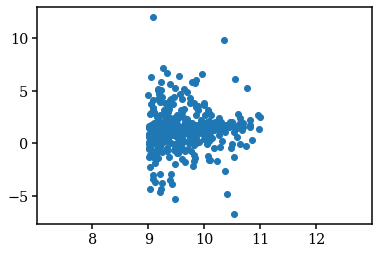

In [7]:
plt.scatter(mass,Xs1[100,:])

In [247]:
print(Xs1.shape)
print(thetas.shape)

(20000, 913)
(20000, 3)


In [8]:
#lower_bounds = torch.tensor([-.3, -1,0.])
#upper_bounds = torch.tensor([1, 1.0,0.5])

lower_bounds = torch.tensor([-.3, -0.5])
upper_bounds = torch.tensor([1.3, 2])
#upper_bounds = torch.tensor([0, 1.5])

bounds = Ut.BoxUniform(low=lower_bounds, high=upper_bounds, device='cpu')

In [9]:
nhidden = 128 
nblocks = 5

maf_model = Ut.posterior_nn('maf', hidden_features=nhidden, num_transforms=nblocks)

In [10]:
anpe = Inference.SNPE(prior=bounds,
                      density_estimator=maf_model,
                      device='cpu')

anpe.append_simulations(
            torch.as_tensor(thetas.astype(np.float32)).to('cpu'),
            torch.as_tensor(Xs1[:,:].astype(np.float32)).to('cpu'))

# estimate p(theta|X)
p_theta_x_est = anpe.train()

 Neural network successfully converged after 66 epochs.

In [11]:
qphi = anpe.build_posterior(p_theta_x_est)

In [12]:
#Xobs = np.asarray(0.1*(mass-10.5)+0.8)+np.random.normal(size=len(mass))*0.7
Xobs = np.array(sel['logSFR100_50'])
#Xobs=((0.1*(np.random.normal(size=len(mass))*(mass_84-mass_16)+mass-10.5)+0.5))+np.random.normal(size=len(mass))*0.1+np.random.normal(size=len(mass))*(sfr_84-sfr_16)


In [16]:
posterior_samples = np.array(qphi.sample((10000,), 
                                x=torch.as_tensor(np.array(Xobs).astype(np.float32)).to('cpu'), 
                                show_progress_bars=False).detach().to('cpu'))

In [15]:
posterior_samples.shape
with open(data_path+'posterior_samples_nosigma_z01_100k.npy', 'wb') as f:
    np.save(f,posterior_samples)

(10000, 2)
[0.3725556  0.96168095]


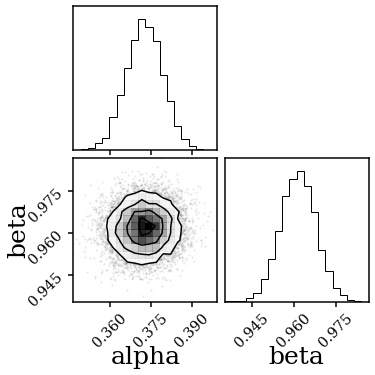

In [17]:
import corner
fig = corner.corner(posterior_samples, 
                     labels=[r'alpha', 'beta','sigma'],
                    label_kwargs={'fontsize': 25},
                     hist_kwargs={'density': True})



print(posterior_samples.shape)
print(np.mean(posterior_samples,axis=0))
#axes = np.array(fig.axes).reshape(2,2)
#ax = axes[0,1]
#ax.plot([], [], c='C0', label='ABC')
#ax.plot([], [], c='C1', label='normalizing flow')
#ax.legend(loc='lower left', fontsize=20)

In [61]:
print(mpl.__version__)

3.4.2


In [ ]:
import seaborn as sns
zbins = [0,1,3,6]
for zlow,zup in zip(zbins[:-1],zbins[1:]):
    sel = ceers_cat.query("zfit_50>"+str(zlow)+"and zfit_50<"+str(zup)+" and logSFR100_50>-5 and logSFR100_50<5 and logM_50>9")
    mass=sel['logM_50']
    zbest = sel["zfit_50"]
    SFR = sel['logSFR100_50']
    morph_flag = sel.morph_flag_f444w
    #fig = plt.figure()
    #fig.set_size_inches(8.5, 8.5)
    #gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                        #left=0.1, right=0.9, bottom=0.1, top=0.9,
                        #wspace=0.05, hspace=0.05)
    #sns.set(font_scale=1.5)
    # Create the Axes.
    #ax = fig.add_subplot(gs[1, 0])
    #ax=px.density_contour(sel, x="logM_50", y="logSFR100_50",marginal_x="histogram", marginal_y="histogram",color='morph_flag_f200w')
    
    graph = sns.jointplot(x=mass[(morph_flag==0)|(morph_flag==3)], y=SFR[(morph_flag==0)|(morph_flag==3)],
                 cmap="Reds", kind="kde", marginal_kws={"color":"r", "fill":"True","alpha":.2}, fill=True, thresh=0.05, alpha=.5,
                 label='Early-Type',color='red')

    #graph.set_axis_labels()
    #p=sns.jointplot(data=sel,x="logM_50", y="logSFR100_50",hue="morph_flag_f200w",palette=['red','blue','green','orange'],kind='kde',marginal_kws=dict(common_norm=False, fill=True))
    
    graph.x = mass[(morph_flag==1)|(morph_flag==2)]
    graph.y = SFR[(morph_flag==1)|(morph_flag==2)]
    graph.plot_joint(sns.kdeplot, cmap="Blues", fill=True, thresh=0.05, alpha=.5, label='Late-Type') 
    graph.set_axis_labels(xlabel='$\log M_*/M_\odot$', ylabel='$\log SFR$',fontsize=16)
    graph.ax_marg_x.set_xlim(8.5, 12)
    graph.ax_marg_y.set_ylim(-4.5, 3)
    
    #graph.legend()
    #plt.legend()
    #ax = plt.gca()
    #ax.legend(loc='lower left',fontsize=16)
    graph.plot_marginals(sns.kdeplot, color='b', fill=True, alpha=.2, legend=False)
    #palette=['red','blue','green','orange']
    #hue="morph_flag_f200w"
    #plt.xlim(7,11)
    #plt.ylim(-4.5,2.5)
    #plt.xticks(fontsize=20, rotation=0)
    #plt.yticks(fontsize=20, rotation=0)
    #plt.ylabel("$\log SFR$",fontsize=20)
    #plt.xlabel("$\log M_*/M_\odot$",fontsize=20)
    #ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
    #ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
    #ax_histx = ax.inset_axes([0, 1.05, 1, 0.25], sharex=ax)
    #ax_histy = ax.inset_axes([1.05, 0, 0.25, 1], sharey=ax)
    #ax.show()
    # Draw the scatter plot and marginals.
    
    
    #scatter_hist(sel.logM_50[morph_flag==1], sel.logSFR100_50[morph_flag==1], ax, ax_histx, ax_histy,[7,11.5],[-4,6],c='blue')
    #scatter_hist(sel.logM_50[morph_flag==2], sel.logSFR100_50[morph_flag==2], ax, ax_histx, ax_histy,[7,11.5],[-4,6],c='green')
    #scatter_hist(sel.logM_50[morph_flag==3], sel.logSFR100_50[morph_flag==3], ax, ax_histx, ax_histy,[7,11.5],[-4,6],c='orange')
    #scatter_hist(sel.logM_50[morph_flag==0], sel.logSFR100_50[morph_flag==0], ax, ax_histx, ax_histy,[7,11.5],[-4,6],c='red')
    plt.text(8.8,-4,str(zlow)+"<z<"+str(zup),fontsize=20)
    plt.savefig(data_path+"SFR_mstar_morph"+str(zlow)+"f444.png")
